In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize

In [2]:
# Probability of d weighted over the Gaussian distribution of Overhauser frequencies
def prob_d(d, t, mu, sig, T):
    return (1+(1-2*d)*np.cos(mu*t)*np.exp( -t**2*(sig**2/2+1/T) ))/2

# The true posterior distribution
def p(x, mu, sig, t, d, T):
    return (np.exp(-(x-mu)**2/(2*sig**2))/np.sqrt(8*np.pi)/sig \
           +np.exp(-(x+mu)**2/(2*sig**2))/np.sqrt(8*np.pi)/sig)*(1 + (-1)**d*np.exp(-(t/T)**2)*np.cos(x*t)) \
            /(2*prob_d(d, t, mu, sig, T))

# Bimodal Gaussian distribution
def q(x, mu, sig):
    return (np.exp(-(x-mu)**2/(2*sig**2))/np.sqrt(8*np.pi*sig**2) \
           +np.exp(-(x+mu)**2/(2*sig**2))/np.sqrt(8*np.pi*sig**2))


# KL-divergence between p and q
def kl_cost(y, mu_o, sig_o, t, d, T):
    mu = y[0]
    sig = y[1]
    
    p_res = 500
    x = np.linspace(-mu_o-5*abs(sig_o), min(-mu_o+5*abs(sig_o), -(mu_o+5*abs(sig_o))/p_res), p_res//2)
    x = np.append(x, np.linspace(max(mu_o-5*abs(sig_o), (mu_o+5*abs(sig_o))/p_res), mu_o+5*abs(sig_o), p_res//2))
    x.sort()
    
    if 5*abs(sig_o) < mu_o:
        dx = 20*abs(sig_o)/p_res
    else:
        dx = (10*abs(sig_o)+2*mu_o)/p_res
    
    return np.sum( p(x, mu_o, sig_o, t, d, T)*np.log(p(x, mu_o, sig_o, t, d, T)/q(x, mu, sig))*dx )


In [3]:
# Example of parameters for the Gaussian prior. For the actual calculations, the calculation must be done for
# all relevant input parameters in the map, which takes a long time and therefore is done on a cluster
mu, sig = 0.001, 0.5
#Towards aysmptotic limit: set f.ex mu, sig = 0.1, 0.01


# Dephasing time (here set to infinity)
T = np.inf

# Using just a single solver didn't allways find the true minimum, so we iterate over a couple of different ones,
# which seems to give stable results.
methods = ['Nelder-Mead', 'Powell', 'L-BFGS-B', 'TNC', 'SLSQP']

# Store Gaussian posterior parameters for d = 0 and d = 1
d0 = [[mu,sig]]
d1 = [[mu,sig]]


# Measurement times to search over, here we have chosen a very large interval. For the actual calculations
# in the paper we used our knowledge of where the minimum would approximately be (ie. somewhere more or less
# close to 1/sig) to drastically reduce this interval.
ts = np.linspace(0, 6/sig, 200)

# Set starting guess for posterior parameters to be the prior parameters 
x0 = np.array([mu, sig])

# Find the Gaussian posterior parameters at each time that minimise the KL-divergence to the true posterior, d = 0
for t in ts[1:]:

    mu_best, sig_best = mu, sig


    for method in methods:
        popt = minimize(kl_cost, x0=x0, args=(mu, sig, t, 0, T), method=method,
                       bounds=[(0,2),(1e-5,1)], options={'disp': False})['x']

        if kl_cost(popt, mu, sig, t, 0, T) < kl_cost((mu_best, sig_best), mu, sig, t, 0, T):
            mu_best, sig_best = popt[0], popt[1]

    x0 = np.array([mu_best, sig_best])
    d0.append([mu_best, sig_best])

# Set starting guess for posterior parameters to be the prior parameters
x0 = np.array([mu, sig])

# Find the Gaussian posterior parameters at each time that minimise the KL-divergence to the true posterior, d = 1
for t in ts[1:]:

    mu_best, sig_best = mu, sig 


    for method in methods:
        popt = minimize(kl_cost, x0=x0, args=(mu, sig, t, 1, T), method=method,
                       bounds=[(0,2),(1e-5,1)], options={'disp': False})['x']

        if kl_cost(popt, mu, sig, t, 1, T) < kl_cost((mu_best, sig_best), mu, sig, t, 1, T):
            mu_best, sig_best = popt[0], popt[1]

    x0 = np.array([mu_best, sig_best])
    d1.append([mu_best, sig_best])


d0 = np.array(d0)
d1 = np.array(d1)

# Calculate the Bayes risk (ie. expected variance)
risk = d0[:,1]**2*prob_d(0, ts, mu, sig, T) + d1[:,1]**2*prob_d(1, ts, mu, sig, T)

# Find risk minimum
min_idx = np.argmin(risk)

/tmp/ipykernel_3791551/795546129.py:32: RuntimeWarning: divide by zero encountered in true_divide
  return np.sum( p(x, mu_o, sig_o, t, d, T)*np.log(p(x, mu_o, sig_o, t, d, T)/q(x, mu, sig))*dx )
/home/jacob/anaconda3/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


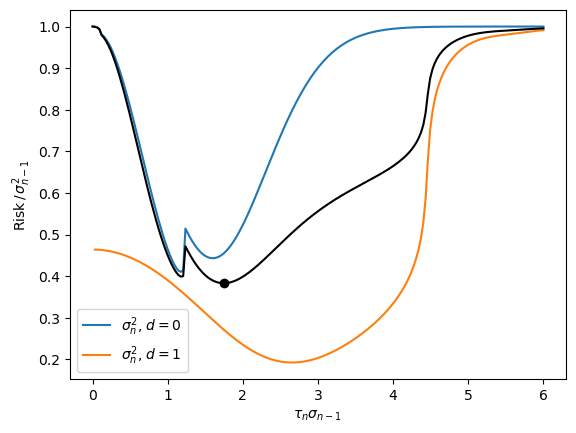

Optimal time for mu_{n-1} = 0.001 , sig_{n-1} = 0.5 is tau_{n} = 3.4974874371859297
Corresponding posterior parameters with d=0 are mu_{n} = 0.0003547374547581139 , sig_{n} = 0.33735778192487376
Corresponding posterior parameters with d=1 are mu_{n} = 0.6275605110038766 , sig_{n} = 0.2602265814373727


In [7]:
plt.figure()
# Blue curve: posterior variance in outcome d = 0
plt.plot(ts*sig, d0[:,1]**2/sig**2, label=r'$\sigma_{n}^2$, $d=0$')
# Orange curve: posterior variance in outcome d = 1
plt.plot(ts[1:]*sig, d1[1:,1]**2/sig**2, label=r'$\sigma_{n}^2$, $d=1$') # Note P(d=1|t=0) = 0
# Black curve: Bayes' risk
plt.plot(ts*sig, risk/sig**2, color='k')
# Black dot: point of optimal measurement time
plt.plot(ts[min_idx]*sig, risk[min_idx]/sig**2, color='k', ls='', marker='o')
plt.xlabel(r'$\tau_n \sigma_{n-1}$')
plt.ylabel(r'Risk$ \, / \, \sigma_{n-1}^2$')
plt.legend()
plt.show()

print('Optimal time for mu_{n-1} =', mu, ', sig_{n-1} =', sig, 'is tau_{n} =', ts[min_idx])
print('Corresponding posterior parameters with d=0 are mu_{n} =', d0[min_idx,0], ', sig_{n} =', d0[min_idx,1])
print('Corresponding posterior parameters with d=1 are mu_{n} =', d1[min_idx,0], ', sig_{n} =', d1[min_idx,1])